In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import csv
import numpy as np
import os
import sqlite3
import copy
from dbfread import DBF
import geopandas as gpd
import fiona
import pprint
import folium
import descartes
import rasterio as rio
import earthpy as et
import pickle
from raster2xyz.raster2xyz import Raster2xyz

print(f"Python Version = {sys.version}")
print(f"Pandas Version = {pd.__version__}")
print(f"Geopandas Version = {gpd.__version__}")
print(f"rasterio version = {rio._base.gdal_version()}")

Python Version = 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 21:48:41) [MSC v.1916 64 bit (AMD64)]
Pandas Version = 1.0.1
Geopandas Version = 0.6.3
rasterio version = 3.0.4


In [2]:
!conda info --envs

# conda environments:
#
base                     /home/laura/anaconda3
TheanoCompatible         /home/laura/anaconda3/envs/TheanoCompatible
geo2                  *  /home/laura/anaconda3/envs/geo2
geo_env                  /home/laura/anaconda3/envs/geo_env



# Definitions

1) Fine Fuel Moisture Code
The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.

2) Duff Moisture Code
The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.

3) Drought Code
The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.

4)  Initial Spread Index
The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It combines the effects of wind and the FFMC on rate of spread without the influence of variable quantities of fuel.

https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

5) Temp
Temperature in Celsius degrees

6) RH
Relative humidity in %

7) Wind
Wind speed in km/h

8) Rain
Outside rain in mm/m2

9) Area
The burned area of the forest (in ha), ha = hectare = 2.47 acres

10) X
x-axis spatial coordinate within the Montesinho park map: 1 to 9 2

11) Y
y-axis spatial coordinate within the Montesinho park map: 2 to 9 3

Literature:

https://news.uci.edu/2019/09/17/uci-team-uses-machine-learning-to-help-tell-which-wildfires-will-burn-out-of-control/

In the original paper (Portugal - Montesinho fires), the best result (predicting burned area) was only using the 4 weather conditions: RH/Wind/Rain/Temp, and an SVM.

This: https://datasetsearch.research.google.com/search?query=wildfire%20area&docid=fchFFzqh0O3qjX3PAAAAAA%3D%3D has georeferenced and date/time referenced with areas. Could combine with weather data for those dates/times.

# Query shape of datasets and feature names

In [3]:
os.getcwd()

'/home/laura/W210/wildfireplus/EDA'

## Montesinho

In [ ]:
montesinho = pd.read_csv('../data/Montesinho/forestfires.csv')

In [22]:
print(montesinho.shape)
montesinho.head()

(517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## US Fires 1.88 Million

In [9]:
db = sqlite3.connect('../data/188millionuswildfires/FPA_FOD_20170508.sqlite')

In [10]:
cursorobj = db.cursor()
cursorobj.execute('SELECT name from sqlite_master where type = "table"')
tables1 = cursorobj.fetchall()
tables1

[('spatial_ref_sys',),
 ('spatialite_history',),
 ('sqlite_sequence',),
 ('geometry_columns',),
 ('spatial_ref_sys_aux',),
 ('views_geometry_columns',),
 ('virts_geometry_columns',),
 ('geometry_columns_statistics',),
 ('views_geometry_columns_statistics',),
 ('virts_geometry_columns_statistics',),
 ('geometry_columns_field_infos',),
 ('views_geometry_columns_field_infos',),
 ('virts_geometry_columns_field_infos',),
 ('geometry_columns_time',),
 ('geometry_columns_auth',),
 ('views_geometry_columns_auth',),
 ('virts_geometry_columns_auth',),
 ('sql_statements_log',),
 ('SpatialIndex',),
 ('ElementaryGeometries',),
 ('KNN',),
 ('Fires',),
 ('idx_Fires_Shape',),
 ('idx_Fires_Shape_node',),
 ('idx_Fires_Shape_rowid',),
 ('idx_Fires_Shape_parent',),
 ('NWCG_UnitIDActive_20170109',)]

In [11]:
tables2 = copy.deepcopy(tables1)
del tables2[18:21]
tables2
del tables2[19]
tables2

[('spatial_ref_sys',),
 ('spatialite_history',),
 ('sqlite_sequence',),
 ('geometry_columns',),
 ('spatial_ref_sys_aux',),
 ('views_geometry_columns',),
 ('virts_geometry_columns',),
 ('geometry_columns_statistics',),
 ('views_geometry_columns_statistics',),
 ('virts_geometry_columns_statistics',),
 ('geometry_columns_field_infos',),
 ('views_geometry_columns_field_infos',),
 ('virts_geometry_columns_field_infos',),
 ('geometry_columns_time',),
 ('geometry_columns_auth',),
 ('views_geometry_columns_auth',),
 ('virts_geometry_columns_auth',),
 ('sql_statements_log',),
 ('Fires',),
 ('idx_Fires_Shape_node',),
 ('idx_Fires_Shape_rowid',),
 ('idx_Fires_Shape_parent',),
 ('NWCG_UnitIDActive_20170109',)]

In [12]:
for table in tables2:
    query = "SELECT * FROM " + table[0]
    #print(query)
    cursorobj.execute(query)
    names = [description[0] for description in cursorobj.description]
    print(table, names)

('spatial_ref_sys',) ['srid', 'auth_name', 'auth_srid', 'ref_sys_name', 'proj4text', 'srtext']
('spatialite_history',) ['event_id', 'table_name', 'geometry_column', 'event', 'timestamp', 'ver_sqlite', 'ver_splite']
('sqlite_sequence',) ['name', 'seq']
('geometry_columns',) ['f_table_name', 'f_geometry_column', 'geometry_type', 'coord_dimension', 'srid', 'spatial_index_enabled']
('spatial_ref_sys_aux',) ['srid', 'is_geographic', 'has_flipped_axes', 'spheroid', 'prime_meridian', 'datum', 'projection', 'unit', 'axis_1_name', 'axis_1_orientation', 'axis_2_name', 'axis_2_orientation']
('views_geometry_columns',) ['view_name', 'view_geometry', 'view_rowid', 'f_table_name', 'f_geometry_column', 'read_only']
('virts_geometry_columns',) ['virt_name', 'virt_geometry', 'geometry_type', 'coord_dimension', 'srid']
('geometry_columns_statistics',) ['f_table_name', 'f_geometry_column', 'last_verified', 'row_count', 'extent_min_x', 'extent_min_y', 'extent_max_x', 'extent_max_y']
('views_geometry_colum

In [13]:
usfires2 = pd.read_sql_query("SELECT datetime(DISCOVERY_DATE) as DISCOVERY_DATE, \
                             DISCOVERY_TIME, FIRE_SIZE, LATITUDE, LONGITUDE, \
                             datetime(CONT_DATE) as CONT_DATE, CONT_TIME \
                             FROM Fires",db)

In [14]:
usfires2.shape

(1880465, 7)

In [15]:
usfires2.head()

,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,CONT_DATE,CONT_TIME
0,2005-02-02 00:00:00,1300,0.10,40.036944,-121.005833,2005-02-02 00:00:00,1730
1,2004-05-12 00:00:00,0845,0.25,38.933056,-120.404444,2004-05-12 00:00:00,1530
2,2004-05-31 00:00:00,1921,0.10,38.984167,-120.735556,2004-05-31 00:00:00,2024
3,2004-06-28 00:00:00,1600,0.10,38.559167,-119.913333,2004-07-03 00:00:00,1400
4,2004-06-28 00:00:00,1600,0.10,38.559167,-119.933056,2004-07-03 00:00:00,1200


In [19]:
usfires2['logArea'] = usfires2.apply(lambda row: np.log(row.FIRE_SIZE+1), axis=1)

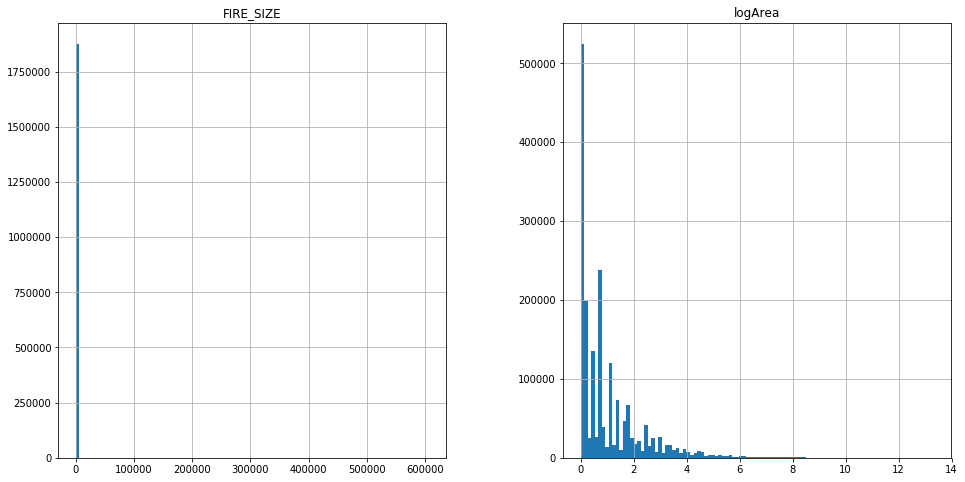

In [21]:
fig,axes = plt.subplots(1,2,figsize=(16,8))
usfires2.hist(column = "FIRE_SIZE", bins=100, ax = axes[0])
usfires2.hist(column = 'logArea', bins=100, ax=axes[1])
plt.show()

In [ ]:
geomac = sqlite3.connect('../data/188millionuswildfires/FPA_FOD_20170508.sqlite')

## Weather Data

1) cheapest seems to be DarkSky. 1000 per day for free
2) $0.0001 per request after that
3) Request: "
https://api.darksky.net/forecast/[key]/40.036944,-121.005833,2005-02-02T17:30:00"  (my api key removed)

Output is like this:
{"latitude":40.036944,"longitude":-121.005833,"timezone":"America/Los_Angeles","currently":{"time":1107394200,"precipIntensity":0,"precipProbability":0,"temperature":50.24,"apparentTemperature":50.41,"dewPoint":13.85,"humidity":0.23,"windSpeed":2.62,"windGust":13.17,"windBearing":24,"uvIndex":0},"hourly":{"data":[{"time":1107331200,"precipIntensity":0,"precipProbability":0,"temperature":39.73,"apparentTemperature":39.73,"dewPoint":12.45,"humidity":0.32,"windSpeed":1.23,"windGust":6.42,"windBearing":140,"uvIndex":0},{"time":1107334800,"precipIntensity":0,"precipProbability":0,"temperature":39.57,"apparentTemperature":39.57,"dewPoint":11.95,"humidity":0.32,"windSpeed":2.21,"windGust":5.8,"windBearing":72,"uvIndex":0},{"time":1107338400,"precipIntensity":0,"precipProbability":0,"temperature":38.69,"apparentTemperature":34.34,"dewPoint":13.27,"humidity":0.35,"windSpeed":5.79,"windGust":14.19,"windBearing":82,"uvIndex":0},{"time":1107342000,"precipIntensity":0,"precipProbability":0,"temperature":37.04,"apparentTemperature":37.04,"dewPoint":12.65,"humidity":0.36,"windSpeed":2.35,"windGust":9.56,"windBearing":98,"uvIndex":0},{"time":1107345600,"precipIntensity":0,"precipProbability":0,"temperature":36.26,"apparentTemperature":36.26,"dewPoint":12.71,"humidity":0.37,"windSpeed":1.16,"windGust":7.66,"windBearing":58,"uvIndex":0},{"time":1107349200,"precipIntensity":0,"precipProbability":0,"temperature":36.51,"apparentTemperature":36.51,"dewPoint":13.58,"humidity":0.39,"windSpeed":2.18,"windGust":6.93,"windBearing":71,"uvIndex":0},{"time":1107352800,"precipIntensity":0,"precipProbability":0,"temperature":36.4,"apparentTemperature":36.4,"dewPoint":12.17,"humidity":0.36,"windSpeed":2.48,"windGust":5.45,"windBearing":16,"uvIndex":0},{"time":1107356400,"precipIntensity":0,"precipProbability":0,"temperature":36.36,"apparentTemperature":36.36,"dewPoint":13.45,"humidity":0.39,"windSpeed":1.74,"windGust":5.3,"windBearing":61,"uvIndex":0},{"time":1107360000,"precipIntensity":0,"precipProbability":0,"temperature":35.85,"apparentTemperature":35.85,"dewPoint":14.88,"humidity":0.42,"windSpeed":2.52,"windGust":6.53,"windBearing":87},{"time":1107363600,"precipIntensity":0,"precipProbability":0,"temperature":42.06,"apparentTemperature":40.19,"dewPoint":13.16,"humidity":0.3,"windSpeed":3.48,"windGust":8.05,"windBearing":91},{"time":1107367200,"precipIntensity":0,"precipProbability":0,"temperature":46.17,"apparentTemperature":46.17,"dewPoint":16.52,"humidity":0.3,"windSpeed":2.71,"windGust":7.32,"windBearing":126},{"time":1107370800,"precipIntensity":0,"precipProbability":0,"temperature":47.55,"apparentTemperature":47.55,"dewPoint":21.59,"humidity":0.36,"windSpeed":2.72,"windGust":10.31,"windBearing":150},{"time":1107374400,"precipIntensity":0,"precipProbability":0,"temperature":52.04,"apparentTemperature":52.04,"dewPoint":20.52,"humidity":0.29,"windSpeed":4.29,"windGust":8.13,"windBearing":87},{"time":1107378000,"precipIntensity":0,"precipProbability":0,"temperature":55.54,"apparentTemperature":55.54,"dewPoint":19.53,"humidity":0.24,"windSpeed":4.84,"windGust":11.03,"windBearing":149},{"time":1107381600,"precipIntensity":0,"precipProbability":0,"temperature":56.34,"apparentTemperature":56.34,"dewPoint":17.37,"humidity":0.21,"windSpeed":5.54,"windGust":11.23,"windBearing":188},{"time":1107385200,"precipIntensity":0,"precipProbability":0,"temperature":57.34,"apparentTemperature":57.34,"dewPoint":15.65,"humidity":0.19,"windSpeed":6.36,"windGust":12.71,"windBearing":107},{"time":1107388800,"precipIntensity":0,"precipProbability":0,"temperature":53.57,"apparentTemperature":53.57,"dewPoint":15.64,"humidity":0.22,"windSpeed":6.13,"windGust":14.53,"windBearing":36},{"time":1107392400,"precipIntensity":0,"precipProbability":0,"temperature":52.58,"apparentTemperature":52.58,"dewPoint":14.07,"humidity":0.21,"windSpeed":3.32,"windGust":14.57,"windBearing":35},{"time":1107396000,"precipIntensity":0,"precipProbability":0,"temperature":47.79,"apparentTemperature":47.79,"dewPoint":13.74,"humidity":0.25,"windSpeed":2.6,"windGust":11.96,"windBearing":13,"uvIndex":0},{"time":1107399600,"precipIntensity":0,"precipProbability":0,"temperature":45.91,"apparentTemperature":43.25,"dewPoint":12.96,"humidity":0.26,"windSpeed":5.25,"windGust":13.55,"windBearing":80,"uvIndex":0},{"time":1107403200,"precipIntensity":0,"precipProbability":0,"temperature":43.25,"apparentTemperature":41.58,"dewPoint":14.25,"humidity":0.31,"windSpeed":3.45,"windGust":8.79,"windBearing":55,"uvIndex":0},{"time":1107406800,"precipIntensity":0,"precipProbability":0,"temperature":43.79,"apparentTemperature":43.79,"dewPoint":14.86,"humidity":0.31,"windSpeed":1.71,"windGust":6.29,"windBearing":158,"uvIndex":0},{"time":1107410400,"precipIntensity":0,"precipProbability":0,"temperature":42.36,"apparentTemperature":42.36,"dewPoint":14.51,"humidity":0.32,"windSpeed":2.37,"windGust":12.25,"windBearing":43,"uvIndex":0},{"time":1107414000,"precipIntensity":0,"precipProbability":0,"temperature":41.2,"apparentTemperature":41.2,"dewPoint":12.53,"humidity":0.31,"windSpeed":1.56,"windGust":12.79,"windBearing":100,"uvIndex":0}]},"daily":{"data":[{"time":1107331200,"sunriseTime":1107357120,"sunsetTime":1107393960,"moonPhase":0.78,"precipIntensity":0,"precipIntensityMax":0,"precipProbability":0,"temperatureHigh":57.95,"temperatureHighTime":1107384600,"temperatureLow":38.42,"temperatureLowTime":1107439200,"apparentTemperatureHigh":57.45,"apparentTemperatureHighTime":1107384600,"apparentTemperatureLow":38.91,"apparentTemperatureLowTime":1107439200,"dewPoint":14.85,"humidity":0.31,"windSpeed":3.33,"windGust":14.83,"windGustTime":1107390840,"windBearing":76,"uvIndex":0,"uvIndexTime":1107331200,"temperatureMin":35.03,"temperatureMinTime":1107359100,"temperatureMax":57.95,"temperatureMaxTime":1107384600,"apparentTemperatureMin":34.3,"apparentTemperatureMinTime":1107338640,"apparentTemperatureMax":57.45,"apparentTemperatureMaxTime":1107384600}]},"flags":{"sources":["cmc","gfs","hrrr","icon","isd","madis","nam","sref"],"nearest-station":3.312,"units":"us"},"offset":-8}

## Global Fire Data  

If you want to see these easily on a map, visit: https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1642  

I have only pulled the 2016 data in in order to get a feel for it.

### DBF file

#### Ignitions

In [294]:
globaldbf = DBF('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.dbf')

In [5]:
len(globaldbf)

887221

In [6]:
records = list(globaldbf)

In [7]:
print(records[0])

OrderedDict([('fire_ID', 1), ('latitude', 20.8438), ('longitude', -156.413), ('size', 0.86), ('perimeter', 4.63), ('start_date', '2016-10-26'), ('start_DOY', 300.0), ('end_date', '2016-11-02'), ('end_DOY', 307.0), ('duration', 8.0), ('expansion', 0.11), ('fire_line', 0.23), ('speed', 0.37), ('direction', 3.0), ('direction_s', 'east'), ('landcover', 12.0), ('landcover_s', 'Croplands'), ('tile_ID', 'h03v06')])


In [295]:
df = pd.DataFrame(iter(globaldbf))

In [296]:
df.head()

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID
0,1,20.8438,-156.413,0.86,4.63,2016-10-26,300.0,2016-11-02,307.0,8.0,0.11,0.23,0.37,3.0,east,12.0,Croplands,h03v06
1,2,20.8396,-156.418,1.50,6.48,2016-10-28,302.0,2016-11-02,307.0,6.0,0.25,0.54,0.57,4.0,southeast,12.0,Croplands,h03v06
2,3,20.8105,-156.437,0.43,2.78,2016-11-29,334.0,2016-11-29,334.0,1.0,0.43,0.93,0.46,0.0,none,12.0,Croplands,h03v06
3,4,20.6271,-156.247,18.65,30.56,2016-02-16,47.0,2016-02-20,51.0,5.0,3.73,6.20,2.68,8.0,northwest,7.0,Open shrublands,h03v06
4,5,19.8063,-155.895,7.72,12.96,2016-03-20,80.0,2016-03-25,85.0,6.0,1.29,2.47,1.39,4.0,southeast,7.0,Open shrublands,h03v07


#### Perimeter

In [10]:
perim2016 = DBF('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.dbf')

In [11]:
perimdf = pd.DataFrame(iter(perim2016))

In [12]:
perimdf.head()

,fire_ID,lat,lon,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID
0,1,20.8438,-156.412,0.86,4.63,2016-10-26,300.0,2016-11-02,307.0,8.0,0.11,0.23,0.37,3.0,east,12.0,Croplands,h03v06
1,2,20.8396,-156.416,1.50,6.48,2016-10-28,302.0,2016-11-02,307.0,6.0,0.25,0.54,0.57,4.0,southeast,12.0,Croplands,h03v06
2,3,20.8104,-156.435,0.43,2.78,2016-11-29,334.0,2016-11-29,334.0,1.0,0.43,0.93,0.46,0.0,none,12.0,Croplands,h03v06
3,4,20.6271,-156.246,18.65,30.56,2016-02-16,47.0,2016-02-20,51.0,5.0,3.73,6.20,2.68,8.0,northwest,7.0,Open shrublands,h03v06
4,5,19.8062,-155.893,7.72,12.96,2016-03-20,80.0,2016-03-25,85.0,6.0,1.29,2.47,1.39,4.0,southeast,7.0,Open shrublands,h03v07


### Shapefile - shp

#### Ignitions

In [13]:
with fiona.open('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.shp') as src:
    pprint.pprint(src[0])

{'geometry': {'coordinates': (-156.4137448816646, 20.843785222895118),
              'type': 'Point'},
 'id': '0',
 'properties': OrderedDict([('fire_ID', 1),
                            ('latitude', 20.8438),
                            ('longitude', -156.413),
                            ('size', 0.86),
                            ('perimeter', 4.63),
                            ('start_date', '2016-10-26'),
                            ('start_DOY', 300),
                            ('end_date', '2016-11-02'),
                            ('end_DOY', 307),
                            ('duration', 8),
                            ('expansion', 0.11),
                            ('fire_line', 0.23),
                            ('speed', 0.37),
                            ('direction', 3),
                            ('direction_s', 'east'),
                            ('landcover', 12),
                            ('landcover_s', 'Croplands'),
                            ('tile_ID', 'h03

In [300]:
gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.shp')

In [8]:
gdf.head()

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,geometry
0,1,20.8438,-156.413,0.86,4.63,2016-10-26,300,2016-11-02,307,8,0.11,0.23,0.37,3,east,12,Croplands,h03v06,POINT (-156.41374 20.84379)
1,2,20.8396,-156.418,1.50,6.48,2016-10-28,302,2016-11-02,307,6,0.25,0.54,0.57,4,southeast,12,Croplands,h03v06,POINT (-156.41833 20.83962)
2,3,20.8105,-156.437,0.43,2.78,2016-11-29,334,2016-11-29,334,1,0.43,0.93,0.46,0,none,12,Croplands,h03v06,POINT (-156.43708 20.81045)
3,4,20.6271,-156.247,18.65,30.56,2016-02-16,47,2016-02-20,51,5,3.73,6.20,2.68,8,northwest,7,Open shrublands,h03v06,POINT (-156.24786 20.62712)
4,5,19.8063,-155.895,7.72,12.96,2016-03-20,80,2016-03-25,85,6,1.29,2.47,1.39,4,southeast,7,Open shrublands,h03v07,POINT (-155.89512 19.80629)


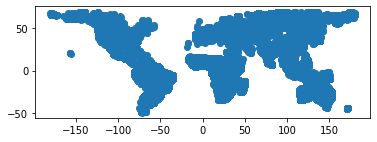

In [4]:
#gdf.plot()

In [15]:
gdf.geometry[:5]

0    POINT (-156.41374 20.84379)
1    POINT (-156.41833 20.83962)
2    POINT (-156.43708 20.81045)
3    POINT (-156.24786 20.62712)
4    POINT (-155.89512 19.80629)
Name: geometry, dtype: geometry

In [16]:
print(gdf.crs)

{'init': 'epsg:4326'}


In [18]:
gdf.columns.values

array(['fire_ID', 'latitude', 'longitude', 'size', 'perimeter',
       'start_date', 'start_DOY', 'end_date', 'end_DOY', 'duration',
       'expansion', 'fire_line', 'speed', 'direction', 'direction_s',
       'landcover', 'landcover_s', 'tile_ID', 'geometry'], dtype=object)

#### Perimeter

In [301]:
gdf1 = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp')

In [19]:
gdf1.head()

,fire_ID,lat,lon,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,geometry
0,1,20.8438,-156.412,0.86,4.63,2016-10-26,300,2016-11-02,307,8,0.11,0.23,0.37,3,east,12,Croplands,h03v06,"POLYGON ((-156.41809 20.84583, -156.40917 20.8..."
1,2,20.8396,-156.416,1.50,6.48,2016-10-28,302,2016-11-02,307,6,0.25,0.54,0.57,4,southeast,12,Croplands,h03v06,"POLYGON ((-156.42268 20.84167, -156.41822 20.8..."
2,3,20.8104,-156.435,0.43,2.78,2016-11-29,334,2016-11-29,334,1,0.43,0.93,0.46,0,none,12,Croplands,h03v06,"POLYGON ((-156.44142 20.81250, -156.43251 20.8..."
3,4,20.6271,-156.246,18.65,30.56,2016-02-16,47,2016-02-20,51,5,3.73,6.20,2.68,8,northwest,7,Open shrublands,h03v06,"POLYGON ((-156.27803 20.65000, -156.26912 20.6..."
4,5,19.8062,-155.893,7.72,12.96,2016-03-20,80,2016-03-25,85,6,1.29,2.47,1.39,4,southeast,7,Open shrublands,h03v07,"POLYGON ((-155.90819 19.80833, -155.88604 19.8..."


In [20]:
gdf1.columns.values

array(['fire_ID', 'lat', 'lon', 'size', 'perimeter', 'start_date',
       'start_DOY', 'end_date', 'end_DOY', 'duration', 'expansion',
       'fire_line', 'speed', 'direction', 'direction_s', 'landcover',
       'landcover_s', 'tile_ID', 'geometry'], dtype=object)

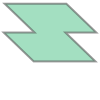

In [21]:
gdf1.geometry[0]

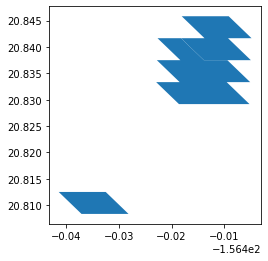

In [22]:
gdf1[0:3].plot()

Wall time: 3min 13s


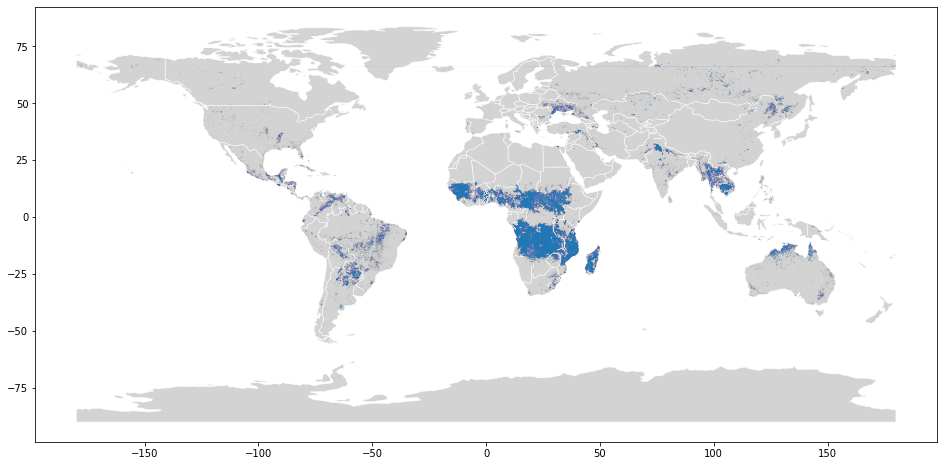

In [304]:
%%time
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='lightgrey',linewidth=0.5,edgecolor='white',figsize = (20,8))
gdf1.plot(ax=ax)
plt.savefig('perimeters.png')

#### Combine Geom Ignition and Perimeter columns into single dataframe. pickle out

In [ ]:
perims = gdf1['geometry']

In [25]:
geomsdf = copy.deepcopy(gdf)

In [30]:
geomsdf.rename(columns={'geometry':'ignition_pt'},inplace=True)

In [32]:
geomsdf['perimeter']=perims

In [37]:
%%time
with open('../data/GlobalFire2016/Global_fire_atlas_V1_combined2016.pickle','wb') as f:
    pickle.dump(geomsdf,f,pickle.HIGHEST_PROTOCOL)

Wall time: 36 s


### PRJ file

In [174]:
with open('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.prj') as f1:
    print(f"Ignitions Prj file contents = {f1.read()}")
    
with open('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.prj','r') as f2:
    print(f"Perimeter Prj file contents = {f2.read()}")    

Ignitions Prj file contents = GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]
Perimeter Prj file contents = GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]


The above mean:
- GEOGCS: Geographic coordinate reference system (vs. a projected coordinate system)
- WGS 84 : the name of the geographic coordinate reference system
- WGS_1984: The name of the DATUM
- SPHEROID: Used for the reference system with the semi major axis = 6378137 m and inverse-flattening ratio of 298.257223563
- PRIMEM: Greenwich is prime meridian where longitude is set as 0
- UNIT: measurement units of coordinate system, in degrees, where 0.01745.. is the conversion from radians to the units here(degrees)

### GEOTiff

#### Monthly TIFF (averages)

In [68]:
dirmth = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_monthly_2016.tif')
dirmth

<open DatasetReader name='../data/GlobalFire2016/Global_fire_atlas_direction_monthly_2016.tif' mode='r'>

In [75]:
print("name = ",dirmth.name)
print("mode = ",dirmth.mode)
print("closed? = ",dirmth.closed)
print("resolution of a pixel in units of coord reference system = ",dirmth.res)
print("Image Structure tags =",dirmth.tags(ns='IMAGE_STRUCTURE'))
print("tags =",dirmth.tags())
dirmth.meta

name =  ../data/GlobalFire2016/Global_fire_atlas_direction_monthly_2016.tif
mode =  r
closed? =  False
resolution of a pixel in units of coord reference system =  (0.25, 0.25)
Image Structure tags = {'COMPRESSION': 'LZW', 'INTERLEAVE': 'PIXEL'}
tags = {'AREA_OR_POINT': 'Area'}


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 1440,
 'height': 720,
 'count': 12,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.25, 0.0, -180.0,
        0.0, -0.25, 90.0)}

In [76]:
dirmth.close()

In [77]:
dirmth.closed

True

In [58]:
print(dirmth.shape)
print(dirmth.bounds)
print("number of layers = ",dirmth.count)
print("number of bands", dirmth.indexes)

(720, 1440)
BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
number of layers =  12
number of bands (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)


In [61]:
dirmth_1 = dirmth.read(1)

In [62]:
dirmth_1.shape

(720, 1440)

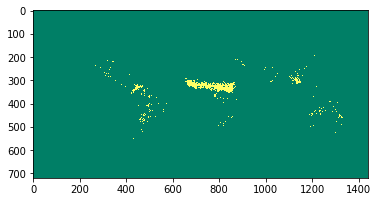

In [72]:
plt.imshow(dirmth_1, cmap='summer')
plt.show()

In [73]:
array = dirmth.read()
array.shape

(12, 720, 1440)

In [63]:
for i, dtype, nodataval in zip(dirmth.indexes, dirmth.dtypes, dirmth.nodatavals):
    print(i, dtype, nodataval)

1 float32 -9999.0
2 float32 -9999.0
3 float32 -9999.0
4 float32 -9999.0
5 float32 -9999.0
6 float32 -9999.0
7 float32 -9999.0
8 float32 -9999.0
9 float32 -9999.0
10 float32 -9999.0
11 float32 -9999.0
12 float32 -9999.0


#### Yearly TIFFs

In [74]:
from rasterio.windows import Window

In [112]:
diryr = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016.tif')
speedyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016.tif')
dobyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_day_of_burn_yearly_2016.tif')
firelineyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_fire_line_yearly_2016.tif')

In [82]:
tifs = [diryr,speedyr,dobyr,firelineyr]

In [87]:
for tif in tifs:
    print("name = ",tif.name)
    print("resolution of a pixel in units of coord reference system = ",tif.res)
    print("Image Structure tags =",tif.tags(ns='IMAGE_STRUCTURE'))
    print("tags =",tif.tags())
    print(tif.shape)
    print(tif.bounds)
    print("number of layers = ",tif.count)
    print("number of bands =", tif.indexes)
    print(tif.meta)
    print("\n\n")

name =  ../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016.tif
resolution of a pixel in units of coord reference system =  (463.3127165279165, 463.3127165279167)
Image Structure tags = {'COMPRESSION': 'LZW', 'INTERLEAVE': 'BAND'}
tags = {'AREA_OR_POINT': 'Area'}
(31200, 81600)
BoundingBox(left=-20015109.354, bottom=-6671703.118005, right=17791208.314677987, top=7783653.637666)
number of layers =  1
number of bands = (1,)
{'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 81600, 'height': 31200, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",

In [149]:
%%time
diryr = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016.tif')
diryr1 = diryr.read(1,window=Window(0,25000,81600,1000))
diryr.close()

Wall time: 668 ms


In [151]:
%%time
speedyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016.tif')
speedyr1 = speedyr.read(1,window=Window(0,25000,81600,1000))
speedyr.close()

Wall time: 1.64 s


In [152]:
%%time
dobyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_day_of_burn_yearly_2016.tif')
dobyr1 = dobyr.read(1,window=Window(0,25000,81600,1000))
dobyr.close()

Wall time: 674 ms


In [153]:
%%time
firelineyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_fire_line_yearly_2016.tif')
firelineyr1 = firelineyr.read(1,window=Window(0,25000,81600,1000))
firelineyr.close()

Wall time: 663 ms


In [157]:
def flathist(arr):
    d = arr.flatten()
    plt.hist(d,bins='auto')
    plt.show

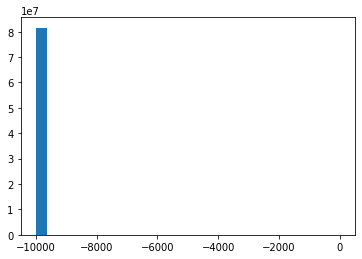

In [159]:
flathist(diryr1)

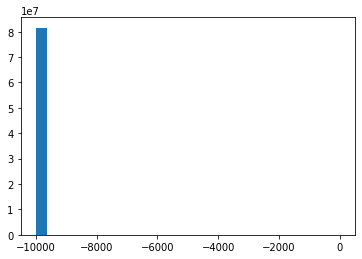

In [160]:
flathist(speedyr1)

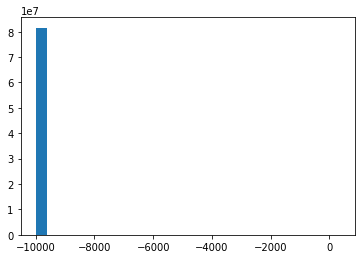

In [161]:
flathist(dobyr1)

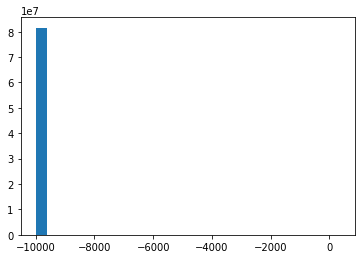

In [162]:
flathist(firelineyr1)

#### Relate TIFF data to a specific fire  

Basically we need to relate a latitude longitude of a specific ignition point (from the yearly ignition file) to a pixel, then use the pixel data to determine the fire spread of that specific fire over time.

In [ ]:
# 2016 yearly data from pickle file
gdf_2016 = pd.read_pickle('../data/GlobalFire2016/Global_fire_atlas_V1_combined2016.pickle')

In [196]:
# Subset df for Fort McMurray fire
ftmc1 = gdf_2016.loc[(gdf_2016['latitude'] > 54.0) & (gdf_2016['latitude'] < 57.0)
                    & (gdf_2016['longitude'] > -113) & (gdf_2016['longitude'] < -110)]
pd.set_option('display.max_rows',86)
ftmc = copy.deepcopy(ftmc1)
ftmc.rename(columns={'perimeter':'geometry'},inplace=True)
ftmc.sort_values(by=['duration'],ascending=False)

,fire_ID,latitude,longitude,size,geometry,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,ignition_pt
34569,34570,56.6604,-111.410,1547.32,"POLYGON ((-110.20500 56.80417, -110.19739 56.8...",2016-05-01,122,2016-05-29,150,29,53.36,68.30,13.21,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-111.41070 56.66044)
34587,34588,56.7563,-110.273,129.91,"POLYGON ((-110.12625 56.82917, -110.11863 56.8...",2016-05-15,136,2016-06-08,160,25,5.20,5.22,13.34,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-110.27352 56.75627)
34540,34541,56.6479,-111.676,369.79,"POLYGON ((-110.39716 56.94167, -110.38952 56.9...",2016-05-12,133,2016-06-04,156,24,15.41,12.94,16.94,8,northwest,1,Evergreen Needleleaf forest,h11v03,POINT (-111.67692 56.64794)
34541,34542,56.6438,-111.694,110.83,"POLYGON ((-110.07299 56.92500, -110.06535 56.9...",2016-05-12,133,2016-06-04,156,24,4.62,6.37,5.94,7,west,1,Evergreen Needleleaf forest,h11v03,POINT (-111.69489 56.64377)
34575,34576,56.8188,-110.069,10.72,"POLYGON ((-111.57656 56.77917, -111.56135 56.7...",2016-05-20,141,2016-06-12,164,24,0.45,0.95,1.69,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-110.06913 56.81877)
34698,34699,56.3188,-110.524,49.52,"POLYGON ((-121.47017 56.31250, -121.46266 56.3...",2016-05-06,127,2016-05-27,148,22,2.25,2.93,6.71,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-110.52454 56.31877)
34559,34560,56.7646,-110.989,71.17,"POLYGON ((-110.76701 56.90417, -110.75175 56.9...",2016-05-15,136,2016-06-04,156,21,3.39,5.73,5.37,8,northwest,1,Evergreen Needleleaf forest,h11v03,POINT (-110.98981 56.76460)
34570,34571,56.6313,-110.468,74.17,"POLYGON ((-110.66162 56.80417, -110.60074 56.8...",2016-05-04,125,2016-05-24,145,21,3.53,4.67,6.57,7,west,1,Evergreen Needleleaf forest,h11v03,POINT (-110.46855 56.63127)
34582,34583,56.6854,-110.892,204.29,"MULTIPOLYGON (((-110.48313 56.78750, -110.4755...",2016-05-04,125,2016-05-24,145,21,9.73,14.97,11.28,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-110.89292 56.68544)
34581,34582,56.7479,-110.401,16.29,"MULTIPOLYGON (((-110.46106 56.75417, -110.4078...",2016-05-04,125,2016-05-24,145,21,0.78,1.61,1.97,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-110.40104 56.74794)


Pick fire # 34570 - that's the biggie.

In [216]:
fire = ftmc.loc[ftmc['fire_ID']==34570]
fire

,fire_ID,latitude,longitude,size,geometry,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,ignition_pt
34569,34570,56.6604,-111.41,1547.32,"POLYGON ((-110.20500 56.80417, -110.19739 56.8...",2016-05-01,122,2016-05-29,150,29,53.36,68.3,13.21,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-111.41070 56.66044)


In [265]:
iy = np.array(fire['latitude'].values[0])
ix = np.array(fire['longitude'].values[0])

array(56.6604)

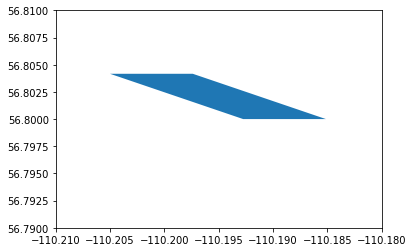

In [293]:
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

ax.plot(ix,iy,marker='x',markersize=12,color='green')
ax.set_xlim([-110.21,-110.18])
ax.set_ylim([56.79,56.81])

fire.plot(ax=ax)

plt.show()

### CANNOT SEEM TO GET THE IGNITION POINT TO SHOW ON THE PLOT. GEOPANDAS DOES DIFFERENT STUFF WITH matplotlib

#### Convert TIFF raster file to point data

In [2]:
# From https://pypi.org/project/raster2xyz/
# input_raster = "input_raster.tif"
# out_csv = "/tmp/out_xyz.csv"

# rtxyz = Raster2xyz()
# rtxyz.translate(input_raster, out_csv)

input_raster = "../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016.tif"
out_csv = "../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_out_xyz.csv"

rtxyz = Raster2xyz()
rtxyz.translate(input_raster, out_csv)

[2020-02-11 10:31:40 - INFO] - Getting geotransform and data...
[2020-02-11 10:32:07 - INFO] - Getting XYZ data...
[2020-02-11 10:33:11 - INFO] - Getting geotransformed coordinates...
[2020-02-11 10:33:12 - INFO] - Building XYZ data...
[2020-02-11 10:34:35 - INFO] - New XYZ (csv file) created...


In [3]:
raster_csv = pd.read_csv('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_out_xyz.csv')
raster_csv.shape

(15498140, 3)

In [4]:
raster_csv.head()

,x,y,z
0,4.896520e+06,7.782495e+06,6
1,4.896520e+06,7.782032e+06,6
2,3.447278e+06,7.769059e+06,6
3,3.447742e+06,7.768596e+06,6
4,3.448205e+06,7.768596e+06,3


Now, use GDAL transformation ( OGRCreateCoordinateTransformation()) to convert from SRS to lat/long

## Alberta

In [77]:
alb_dbf = DBF('../data/Alberta/HistoricalWildfirePerimeters/WilfirePerimeters1931to2019.dbf')

In [78]:
len(alb_dbf)

45211

In [79]:
dfalb = pd.DataFrame(iter(alb_dbf))
dfalb.head()

,OBJECTID,FIRENUMBER,FIRE_NUMBE,FIRE_CLASS,BURNCODE,BURN_CLASS,HECTARES_U,YEAR,ALIAS,CAPTURE_DA,TIME,SOURCE,SHAPE_Leng,SHAPE_Area
0,1,REF-001-1931,REF001,E,B,5,1256.0,1931,,1931-99-99,1200,"14 - Publication ISBN 0-662-15280-8 (1:500,000)",22339.077980,1.254048e+07
1,2,REF-001-1931,REF001,E,B,5,1118.9,1931,,1931-99-99,1200,"14 - Publication ISBN 0-662-15280-8 (1:500,000)",24687.358921,1.117232e+07
2,3,REF-002-1932,REF002,E,B,5,6441.1,1932,,1932-99-99,1200,"14 - Publication ISBN 0-662-15280-8 (1:500,000)",42069.833346,6.439967e+07
3,4,REF-003-1932,REF003,E,B,5,727.9,1932,,1932-99-99,1200,"14 - Publication ISBN 0-662-15280-8 (1:500,000)",11375.479857,7.281131e+06
4,5,REF-004-1932,REF004,E,B,5,636.6,1932,,1932-99-99,1200,"14 - Publication ISBN 0-662-15280-8 (1:500,000)",12228.593322,6.365949e+06


In [86]:
alb_gdf = gpd.read_file('../data/Alberta/HistoricalWildfirePerimeters/WilfirePerimeters1931to2019.shp')

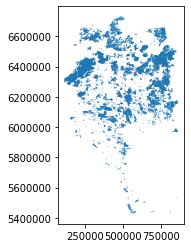

In [87]:
alb_gdf.plot()

In [88]:
alb_gdf.head()

,OBJECTID,FIRENUMBER,FIRE_NUMBE,FIRE_CLASS,BURNCODE,BURN_CLASS,HECTARES_U,YEAR,ALIAS,CAPTURE_DA,TIME,SOURCE,SHAPE_Leng,SHAPE_Area,geometry
0,1,REF-001-1931,REF001,E,B,5,1256.0,1931,None,1931-99-99,1200,"14 - Publication ISBN 0-662-15280-8 (1:500,000)",22339.077980,1.254048e+07,"POLYGON ((535421.166 5489014.589, 535305.852 5..."
1,2,REF-001-1931,REF001,E,B,5,1118.9,1931,None,1931-99-99,1200,"14 - Publication ISBN 0-662-15280-8 (1:500,000)",24687.358921,1.117232e+07,"POLYGON ((522722.919 5487721.868, 522557.591 5..."
2,3,REF-002-1932,REF002,E,B,5,6441.1,1932,None,1932-99-99,1200,"14 - Publication ISBN 0-662-15280-8 (1:500,000)",42069.833346,6.439967e+07,"POLYGON ((335417.909 6165963.257, 335413.322 6..."
3,4,REF-003-1932,REF003,E,B,5,727.9,1932,None,1932-99-99,1200,"14 - Publication ISBN 0-662-15280-8 (1:500,000)",11375.479857,7.281131e+06,"POLYGON ((257622.401 6214291.947, 257773.388 6..."
4,5,REF-004-1932,REF004,E,B,5,636.6,1932,None,1932-99-99,1200,"14 - Publication ISBN 0-662-15280-8 (1:500,000)",12228.593322,6.365949e+06,"POLYGON ((303804.821 6098297.016, 303537.782 6..."


## Geomac

### Event Polygon

In [135]:
gmdbf = DBF('../data/GeoMac/EventPolygon.dbf', encoding='UTF-8')

In [139]:
dfgmac = pd.DataFrame(iter(gmdbf))
#dfgmac[210:215]
#same data in shp file, shp file has geometry added. not showing this one

In [96]:
gm_gdf = gpd.read_file('../data/GeoMac/EventPolygon.shp')

In [103]:
pd.set_option('display.max_columns', 500)

In [109]:
gm_gdf[210:215]

,IncidentNa,FeatureCat,MapMethod,Comments,GISAcres,DeleteThis,Label,FeatureAcc,FeatureSta,IsVisible,CreateDate,DateCurren,PolygonDat,ComplexNam,ComplexID,GACC,IMTName,UnitID,LocalIncid,IRWINID,GeometryID,GlobalID,GDB_ARCHIV,GDB_FROM_D,GDB_TO_DAT,OBJECTID,Shape__Are,Shape__Len,geometry
210,Flathead Lake,IR Intense Heat,Mixed Methods,Flown on 20180322 @ 2200 hrs,3963.880005,No,None,Cooperators,Approved,Yes,2018-04-03T20:03:24.000Z,2018-04-03T20:03:24.000Z,None,None,None,NRCC,Goke,MT - LNF,12345,{6E662394-42EA-4F4F-8E95-99AD0E37E95E},None,401f9421-f1de-45c5-899e-88828e58868e,211,2018-04-03T20:04:14.000Z,2018-04-04T09:48:39.000Z,6412,1.928445e-03,0.162579,"POLYGON ((-114.09006 47.88280, -114.10002 47.8..."
211,Flathead Lake,Retardant Avoidance Area,Mixed Methods,None,469.981871,No,None,Cooperators,Approved,Yes,2018-04-03T20:03:24.000Z,2018-04-03T20:03:24.000Z,None,None,None,NRCC,Goke,MT - LNF,12345,{6E662394-42EA-4F4F-8E95-99AD0E37E95E},None,43e3730f-8d25-4314-a155-aeee11e9b938,212,2018-04-03T20:04:14.000Z,2018-04-04T09:48:39.000Z,6413,2.286127e-04,0.063586,"POLYGON ((-114.00858 47.87785, -114.01545 47.8..."
212,Colony Area,Wildfire Daily Fire Perimeter,Auto-generated,Auto-generated by EGP-IRWIN,10.000000,No,None,Cooperators,proposed,-1,2018-04-03T20:38:33.000Z,2018-04-03T20:38:33.000Z,2018-04-04T03:37:09.000Z,None,None,SACC,None,None,000771,f11e0f81-7852-4e49-a3df-a465a2647415,496921bc-274d-4c5c-8691-4ab219cdea7b,7531f0cc-26a5-4d94-9866-9b8639b4cffa,213,2018-04-03T20:38:33.000Z,2018-06-13T21:57:42.000Z,6414,2.663454e-06,0.007499,"POLYGON ((-98.66905 35.35374, -98.67179 35.353..."
213,Whiskenboo,Wildfire Daily Fire Perimeter,Auto-generated,Auto-generated by EGP-IRWIN,0.100000,No,None,Cooperators,proposed,-1,2018-04-03T20:57:25.000Z,2018-04-03T20:57:25.000Z,2018-04-04T02:28:27.000Z,None,None,SACC,None,None,000144,07426700-1dd7-443d-b0a6-c8fa7d404baa,e93210a2-c53e-42fb-baa2-9b51d8622af6,6c95456a-6e41-46e1-93d0-ac676efa0112,214,2018-04-03T20:57:25.000Z,2018-06-13T16:22:29.000Z,6415,2.735237e-08,0.000759,"POLYGON ((-79.80170 33.11601, -79.80197 33.116..."
214,GARBAGE CAN 1,Wildfire Daily Fire Perimeter,Auto-generated,Auto-generated by EGP-IRWIN,1.000000,No,None,Cooperators,proposed,-1,2018-04-03T21:20:23.000Z,2018-04-03T21:20:23.000Z,2018-04-04T04:01:00.000Z,None,None,NRCC,None,None,000001,3a27373b-62bd-428e-b2b3-a188f43e0931,38e347c1-bfa3-4727-b254-75cd994ef916,b66e3c49-f7c0-45df-9e74-17fe1508356e,215,2018-04-03T21:20:22.000Z,2018-06-13T16:22:29.000Z,6416,2.148463e-07,0.002185,"POLYGON ((-99.67735 48.86123, -99.67822 48.861..."


In [100]:
gm_gdf.shape

(46529, 29)

In [141]:
sortedgdf = gm_gdf.sort_values(by=['IRWINID'])
sortedgdf.head()

,IncidentNa,FeatureCat,MapMethod,Comments,GISAcres,DeleteThis,Label,FeatureAcc,FeatureSta,IsVisible,CreateDate,DateCurren,PolygonDat,ComplexNam,ComplexID,GACC,IMTName,UnitID,LocalIncid,IRWINID,GeometryID,GlobalID,GDB_ARCHIV,GDB_FROM_D,GDB_TO_DAT,OBJECTID,Shape__Are,Shape__Len,geometry
10055,MM 192,Wildfire Final Fire Perimeter,GPS-Driven,None,83.466818,No,None,Public,Approved,Yes,2018-06-15T20:11:46.000Z,2018-06-15T20:11:46.000Z,2018-06-08T04:00:00.000Z,None,None,GBCC,None,None,20121,\t074D1AAB-B9DF-4F73-9348-395D68A16D94,None,a4b950e8-93b6-414e-854c-f240e86bab53,10066,2018-06-15T20:13:44.000Z,2018-07-31T21:22:05.000Z,170784,3.615911e-05,0.031001,"MULTIPOLYGON (((-117.51547 40.96560, -117.5154..."
10056,MM 192,Wildfire Final Fire Perimeter,GPS-Driven,None,83.529848,No,None,Public,Approved,Yes,2018-06-15T20:11:46.000Z,2018-07-31T21:22:05.000Z,2018-06-08T04:00:00.000Z,None,None,GBCC,None,None,20121,\t074D1AAB-B9DF-4F73-9348-395D68A16D94,None,a4b950e8-93b6-414e-854c-f240e86bab53,10067,2018-07-31T21:22:05.000Z,2018-08-02T22:26:23.000Z,170784,3.615911e-05,0.031001,"MULTIPOLYGON (((-117.51547 40.96560, -117.5154..."
10057,MM 192,Wildfire Daily Fire Perimeter,GPS-Driven,None,83.529848,No,None,Public,Approved,Yes,2018-06-15T20:11:46.000Z,2018-08-02T22:25:14.000Z,2018-06-08T04:00:00.000Z,None,None,GBCC,None,None,20121,\t074D1AAB-B9DF-4F73-9348-395D68A16D94,None,a4b950e8-93b6-414e-854c-f240e86bab53,10068,2018-08-02T22:26:23.000Z,2018-08-03T22:45:09.000Z,170784,3.615911e-05,0.031001,"MULTIPOLYGON (((-117.51547 40.96560, -117.5154..."
33313,Wigwam,Wildfire Daily Fire Perimeter,Mixed Methods,None,17.445764,No,None,Public,Approved,Yes,2018-08-20T23:50:25.000Z,2018-08-26T18:15:52.000Z,None,None,None,NRCC,SoCal Team 3,MTBDF,003305,\t44869022-8CB5-458D-AC2D-15D14EC5DE15,4f36f7e5-0f60-424a-999f-84bfebff1d93,7e8b32af-c8fa-4e43-abd5-dca1e7a7b2e7,33325,2018-08-26T18:17:10.000Z,2018-09-04T22:38:08.000Z,490389,8.085116e-06,0.013853,"POLYGON ((-111.93541 45.16315, -111.93476 45.1..."
33369,Wigwam,Wildfire Daily Fire Perimeter,Mixed Methods,None,0.198267,No,None,Public,Approved,Yes,2018-08-20T23:50:26.000Z,2018-08-26T18:15:52.000Z,None,None,None,NRCC,SoCal Team 3,MTBDF,003305,\t44869022-8CB5-458D-AC2D-15D14EC5DE15,4302edd6-e01f-47b9-bd2c-a9105bcd4964,32d2128a-44af-440e-a378-9ee84142884d,33381,2018-08-26T18:17:10.000Z,2018-09-04T22:39:17.000Z,490398,9.183441e-08,0.001159,"POLYGON ((-111.89980 45.12917, -111.89990 45.1..."


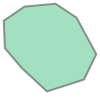

In [107]:
gm_gdf.geometry[210]

## CWFIS Large Fires

In [117]:
canlg_dbf = DBF('../data/CWFIS/NFDB_poly_20190607_large_fires.dbf',encoding='UTF-8')

In [119]:
df_canlg = pd.DataFrame(iter(canlg_dbf))
df_canlg.shape

(21375, 25)

In [123]:
df_canlg[20000:20015]

,SRC_AGENCY,FIRE_ID,FIRENAME,YEAR,MONTH,DAY,REP_DATE,DATE_TYPE,OUT_DATE,DECADE,SIZE_HA,CALC_HA,CAUSE,MAP_SOURCE,SOURCE_KEY,MAP_METHOD,WATER_REM,UNBURN_REM,MORE_INFO,POLY_DATE,CFS_REF_ID,CFS_NOTE1,CFS_NOTE2,AG_SRCFILE,ACQ_DATE
20000,NWT,2000VQ-025,,2000,7,17,2000-07-17,Startdate,None,2000-2009,2614.336,2625.615863,L,N/A,,,,,,None,NWT-2000-2000VQ-025,,,NWT Fire_History_2009.shp,2010-12-16
20001,NWT,2000CR-003,,2000,6,19,2000-06-19,Startdate,None,2000-2009,2695.758,2685.154501,L,N/A,,,,,,None,NWT-2000-2000CR-003,,,NWT Fire_History_2009.shp,2010-12-16
20002,NWT,2000CR-009,,2000,7,8,2000-07-08,Startdate,None,2000-2009,5761.846,5744.735547,L,N/A,,,,,,None,NWT-2000-2000CR-009,,,NWT Fire_History_2009.shp,2010-12-16
20003,NWT,2000CR-010,,2000,7,8,2000-07-08,Startdate,None,2000-2009,9300.668,9250.663417,L,N/A,,,,,,None,NWT-2000-2000CR-010,,,NWT Fire_History_2009.shp,2010-12-16
20004,NWT,2000CR-013,,2000,7,18,2000-07-18,Startdate,None,2000-2009,1983.028,1972.366112,L,N/A,,,,,,None,NWT-2000-2000CR-013,,,NWT Fire_History_2009.shp,2010-12-16
20005,NWT,2000CR-019,,2000,8,2,2000-08-02,Startdate,None,2000-2009,3886.902,3891.066591,L,N/A,,,,,,None,NWT-2000-2000CR-019,,,NWT Fire_History_2009.shp,2010-12-16
20006,NWT,2000CR-028,,2000,8,4,2000-08-04,Startdate,None,2000-2009,464.089,463.989049,L,N/A,,,,,,None,NWT-2000-2000CR-028,,,NWT Fire_History_2009.shp,2010-12-16
20007,NWT,2000CR-005,,2000,6,19,2000-06-19,Startdate,None,2000-2009,281.969,280.971620,L,N/A,,,,,,None,NWT-2000-2000CR-005,,,NWT Fire_History_2009.shp,2010-12-16
20008,NWT,2000CR-012,,2000,7,18,2000-07-18,Startdate,None,2000-2009,660.390,657.696451,L,N/A,,,,,,None,NWT-2000-2000CR-012,,,NWT Fire_History_2009.shp,2010-12-16
20009,NWT,2000ZF-048,,2000,7,17,2000-07-17,Startdate,None,2000-2009,1349.197,1354.630606,L,N/A,,,,,,None,NWT-2000-2000ZF-048,,,NWT Fire_History_2009.shp,2010-12-16


## BC

In [132]:
bc_dbf = DBF('../data/BC/PROT_HISTORICAL_FIRE_POLYS_SP/H_FIRE_PLY_polygon.dbf',encoding='UTF-8')

In [133]:
df_bc = pd.DataFrame(iter(bc_dbf))
df_bc.shape

(22207, 16)

In [142]:
df1_bc = df_bc.sort_values(by=['FIRELABEL'])
df1_bc[20000:20010]

,FIRE_NO,VERSION_NO,FIRE_YEAR,FIRE_CAUSE,FIRELABEL,SIZE_HA,SOURCE,TRACK_DATE,LOAD_DATE,FIRE_DATE,METHOD,FCODE,SHAPE,OBJECTID,AREA_SQM,FEAT_LEN
20335,G70005,2.013043e+09,2013,Person,2013-G70005,23.5,OZIX,20130425,20130425,20130423,GPS-TRACK,JA70003000,None,1372416,235632.8302,2023.1076
20354,G70012,2.013043e+09,2013,Person,2013-G70012,33.9,OZIX,20130428,20130428,20130427,GPS-TRACK,JA70003000,None,1372418,339111.6936,3713.3696
20355,G70013,2.013043e+09,2013,Person,2013-G70013,3.9,OZIX,20130429,20130429,20130428,GPS-TRACK,JA70003000,None,1372419,39857.5587,923.9305
20127,G70024,2.013050e+09,2013,Person,2013-G70024,51.6,OZIX,20130505,20130505,20130504,GPS-TRACK,JA70003000,None,1372425,516070.1440,6868.0206
20128,G70026,2.013050e+09,2013,Person,2013-G70026,3.3,OZIX,20130505,20130505,20130504,GPS-TRACK,JA70003000,None,1372426,33333.7481,889.3940
20337,G70027,2.013051e+09,2013,Person,2013-G70027,68.7,OZIX,20130611,20130611,20130505,GPS-TRACK,JA70003000,None,1372468,687648.9424,4060.2241
20339,G70030,2.013062e+09,2013,Person,2013-G70030,48.0,OZIX,20130620,20130620,20130505,GPS-TRACK,JA70003000,None,1372470,480789.1955,3669.0389
20338,G70035,2.013051e+09,2013,Person,2013-G70035,40.5,OZIX,20130611,20130611,20130425,GPS-TRACK,JA70003000,None,1372469,405305.5485,3530.7840
20150,G70039,2.013051e+09,2013,Person,2013-G70039,79.5,OZIX,20130508,20130508,20130501,GPS-TRACK,JA70003000,None,1372433,795821.5310,7236.0028
20340,G70042,2.013051e+09,2013,Person,2013-G70042,60.7,OZIX,20130620,20130620,20130506,GPS-TRACK,JA70003000,None,1372471,607455.5359,3493.7346
